### Problem Statement

Forecast the CocaCola prices data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
coca_cola=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
coca_cola.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


### Data Understanding

In [3]:
coca_cola.shape

(42, 2)

In [4]:
coca_cola.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
coca_cola.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
coca_cola[coca_cola.duplicated()]

,Quarter,Sales


### Data Preparation

In [7]:
coca_cola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [8]:
coca_cola['date']=pd.to_datetime(['19'+x[3:5]+'-'+x[:2] for x in coca_cola['Quarter']])
coca_cola.head()

,Quarter,Sales,date
0,Q1_86,1734.827000,1986-01-01
1,Q2_86,2244.960999,1986-04-01
2,Q3_86,2533.804993,1986-07-01
3,Q4_86,2154.962997,1986-10-01
4,Q1_87,1547.818996,1987-01-01


In [9]:
coca_cola_test = coca_cola[['Sales','date']]
coca_cola_test=coca_cola_test.set_index('date')
coca_cola_test.head()

,Sales
date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


In [10]:
weekly_sales=coca_cola_test.resample('W').mean()
weekly_sales.head()

,Sales
date,
1986-01-05,1734.827
1986-01-12,NaN
1986-01-19,NaN
1986-01-26,NaN
1986-02-02,NaN


In [11]:
sales_interpolate=weekly_sales.interpolate(method='linear').round()
sales_interpolate.head()

,Sales
date,
1986-01-05,1735.0
1986-01-12,1774.0
1986-01-19,1813.0
1986-01-26,1853.0
1986-02-02,1892.0


In [12]:
monthly_sales=sales_interpolate.resample('M').mean()
monthly_sales.head()

,Sales
date,
1986-01-31,1793.75
1986-02-28,1950.75
1986-03-31,2127.20
1986-04-30,2278.25
1986-05-31,2367.00


In [13]:
monthly_sales.shape

(124, 1)

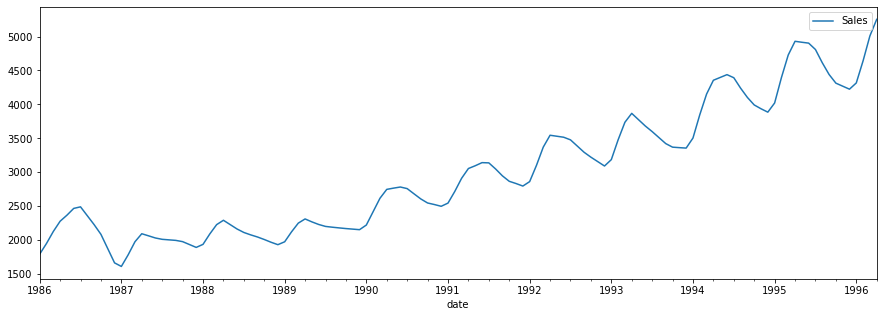

In [14]:
monthly_sales.plot(figsize = (15,5))
plt.show()

In [15]:
monthly_sales['date']=monthly_sales.index
monthly_sales.head()

,Sales,date
date,,
1986-01-31,1793.75,1986-01-31
1986-02-28,1950.75,1986-02-28
1986-03-31,2127.20,1986-03-31
1986-04-30,2278.25,1986-04-30
1986-05-31,2367.00,1986-05-31


In [16]:
monthly_sales=monthly_sales.reset_index(drop=True)
monthly_sales.head()

,Sales,date
0,1793.75,1986-01-31
1,1950.75,1986-02-28
2,2127.20,1986-03-31
3,2278.25,1986-04-30
4,2367.00,1986-05-31


In [17]:
monthly_sales['year']=monthly_sales['date'].dt.strftime('%Y')
monthly_sales['month']=monthly_sales['date'].dt.strftime('%b')
monthly_sales.head()

,Sales,date,year,month
0,1793.75,1986-01-31,1986,Jan
1,1950.75,1986-02-28,1986,Feb
2,2127.20,1986-03-31,1986,Mar
3,2278.25,1986-04-30,1986,Apr
4,2367.00,1986-05-31,1986,May


In [18]:
monthly_sales.dtypes

Sales           float64
date     datetime64[ns]
year             object
month            object
dtype: object

### Data Visualization

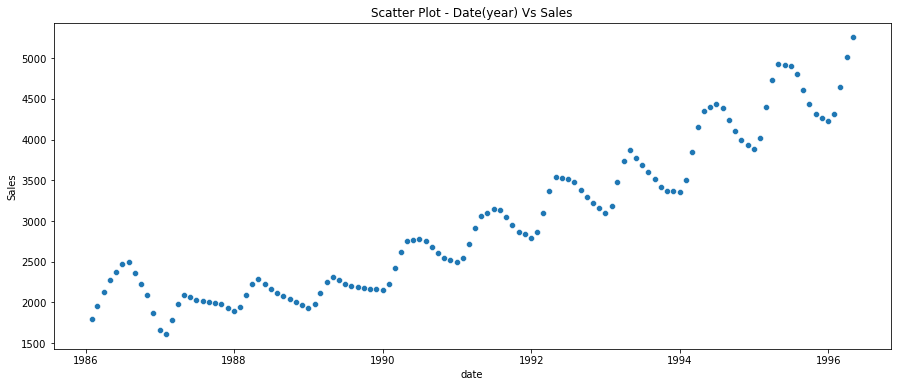

In [19]:
plt.figure(figsize=(15,6))
sns.scatterplot(monthly_sales.date,monthly_sales.Sales)
plt.title('Scatter Plot - Date(year) Vs Sales')
plt.show()

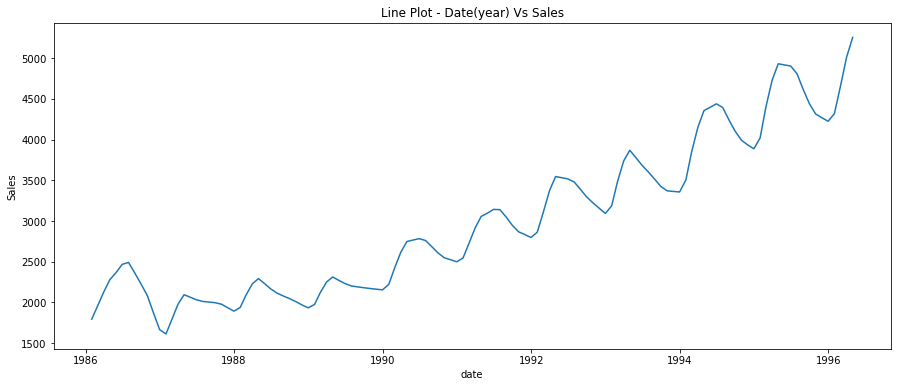

In [20]:
plt.figure(figsize=(15,6))
sns.lineplot(monthly_sales.date,monthly_sales.Sales)
plt.title('Line Plot - Date(year) Vs Sales')
plt.show()

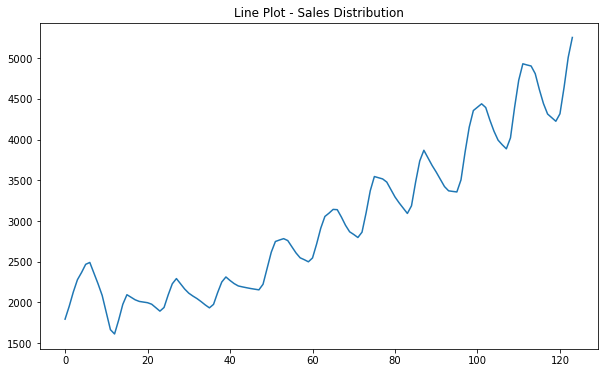

In [21]:
monthly_sales.Sales.plot(figsize=(10,6))
plt.title('Line Plot - Sales Distribution')
plt.show()

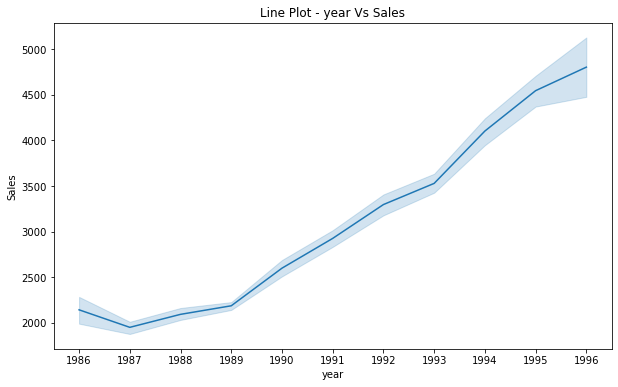

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(monthly_sales.year,monthly_sales.Sales)
plt.title('Line Plot - year Vs Sales')
plt.show()

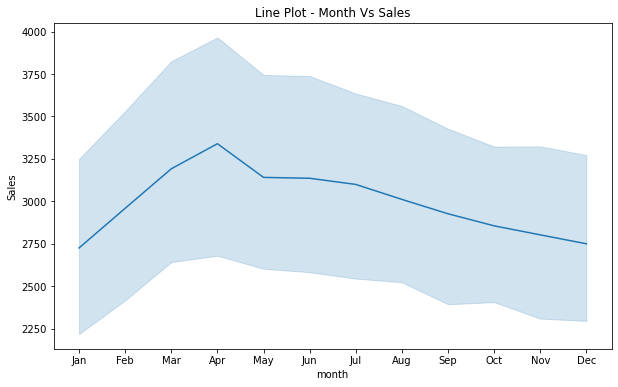

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot(monthly_sales.month,monthly_sales.Sales)
plt.title('Line Plot - Month Vs Sales')
plt.show()

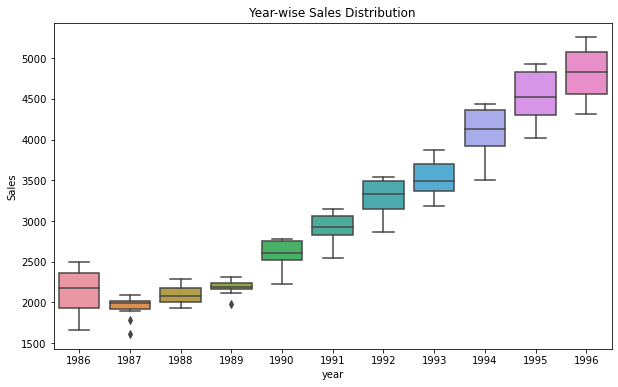

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(monthly_sales.year,monthly_sales.Sales)
plt.title('Year-wise Sales Distribution')
plt.show()

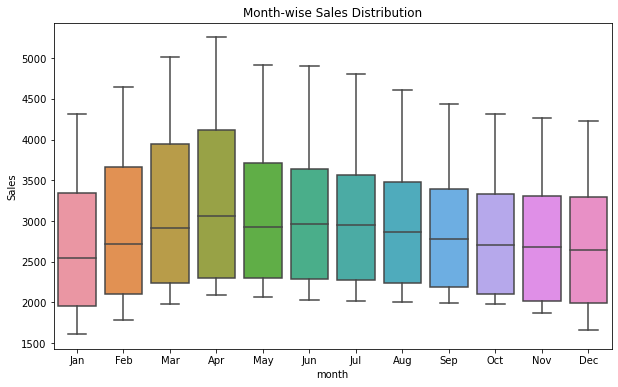

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(monthly_sales.month,monthly_sales.Sales)
plt.title('Month-wise Sales Distribution')
plt.show()

In [26]:
monthwise=pd.pivot_table(data=monthly_sales,values='Sales',index='month',columns='year').round()
monthwise

year,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996
month,,,,,,,,,,,
Apr,2278.0,2094.0,2292.0,2312.0,2748.0,3055.0,3545.0,3868.0,4356.0,4930.0,5253.0
Aug,2359.0,2004.0,2078.0,2190.0,2682.0,3048.0,3386.0,3511.0,4239.0,4614.0,NaN
Dec,1665.0,1892.0,1933.0,2154.0,2498.0,2797.0,3092.0,3356.0,3886.0,4224.0,NaN
Feb,1951.0,1784.0,2091.0,2121.0,2419.0,2718.0,3101.0,3478.0,3847.0,4395.0,4642.0
Jan,1794.0,1612.0,1937.0,1975.0,2222.0,2546.0,2862.0,3186.0,3504.0,4020.0,4316.0
Jul,2490.0,2012.0,2113.0,2202.0,2759.0,3138.0,3478.0,3600.0,4393.0,4809.0,NaN
Jun,2467.0,2032.0,2164.0,2230.0,2782.0,3142.0,3516.0,3681.0,4438.0,4903.0,NaN
Mar,2127.0,1976.0,2228.0,2250.0,2616.0,2911.0,3370.0,3737.0,4152.0,4728.0,5009.0
May,2367.0,2063.0,2228.0,2269.0,2766.0,3096.0,3531.0,3774.0,4397.0,4916.0,NaN


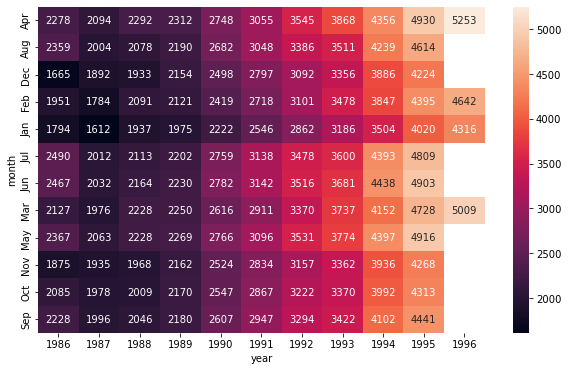

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(monthwise,annot=True,fmt='g')
plt.show()

### Data Preparation - Part 2.

In [28]:
t=np.arange(1,monthly_sales.shape[0]+1)
t_square=t*t
log_sales=np.log(monthly_sales['Sales'])
dummies=pd.get_dummies(monthly_sales['month'])

In [29]:
monthly_sales['t']=pd.Series(t)
monthly_sales['t_square']=pd.Series(t_square)
monthly_sales['log_sales']=pd.Series(log_sales)
monthly_sales=monthly_sales.join(dummies)

In [30]:
monthly_sales.head()

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,0,1,0,0,0,0,0,0,0
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,1,0,0,0,0,0,0,0,0
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,0,0,0,0,1,0,0,0,0
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,0,0,0,0,0,0,0,0,0
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,0,0,0,0,0,1,0,0,0


## 1. Model Driven Forecasting Technique

### Model Building

In [31]:
training_data=monthly_sales.head(monthly_sales.shape[0]-12)
testing_data=monthly_sales.tail(12)
training_data.shape,testing_data.shape

((112, 19), (12, 19))

### Model Training || Model Prediction || Model Evaluation

#### Linear Model

In [32]:
linear_model = smf.ols(formula='Sales~t',data=training_data).fit()

pred_linear=linear_model.predict(testing_data)

linear_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_linear,squared=False),3)
linear_rmse

532.233

#### Exponential Model

In [33]:
exponential_model = smf.ols(formula='log_sales~t',data=training_data).fit()

pred_exponential=exponential_model.predict(testing_data)

exponential_rmse=np.round(mean_squared_error(testing_data['Sales'],np.exp(pred_exponential),squared=False),3)
exponential_rmse

401.303

#### Quadratic Model

In [34]:
quadratic_model = smf.ols(formula='Sales~t+t_square',data=training_data).fit()

pred_quadratic=quadratic_model.predict(testing_data)

quadratic_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_quadratic,squared=False),3)
quadratic_rmse

418.355

#### Additive Seasonality Model

In [35]:
additive_model = smf.ols(formula='Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_additive=additive_model.predict(testing_data)

additive_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_additive,squared=False),3)
additive_rmse

1831.177

#### Additive Seasonality with Quadratic Trend Model

In [36]:
additive_quad_model = smf.ols(formula='Sales~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_additive_quad=additive_quad_model.predict(testing_data)

additive_quad_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_additive_quad,squared=False),3)
additive_quad_rmse

286.272

#### Multiplicative Model

In [37]:
multiplicative_model = smf.ols(formula='log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_multiplicative=multiplicative_model.predict(testing_data)

multiplicative_rmse=np.round(mean_squared_error(testing_data['Sales'],np.exp(pred_multiplicative),squared=False),3)
multiplicative_rmse

1931.699

### Compare the Results

In [38]:
Model_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Linear','Exponential','Quadrative','Additive','Additive with Quadrative','Multiplicative']),
          "RMSE":pd.Series([linear_rmse,exponential_rmse,quadratic_rmse,additive_rmse,additive_quad_rmse,multiplicative_rmse])})
Model_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
4,Additive with Quadrative,286.272
1,Exponential,401.303
2,Quadrative,418.355
0,Linear,532.233
3,Additive,1831.177
5,Multiplicative,1931.699


#### From Model Driven Techniques, We can see that Additive with Quadrative Model gives least Root Mean Squared Error

### Build model for Complete Dataset

In [39]:
final_model=smf.ols('Sales~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=monthly_sales).fit()

In [40]:
final_test_data=pd.read_excel('cocacola_test.xlsx')
final_test_data.head()

,date,t,t_square,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1996-05-31,125,15625,0,0,0,0,0,0,0,0,1,0,0,0
1,1996-06-30,126,15876,0,0,0,0,0,0,1,0,0,0,0,0
2,1996-07-31,127,16129,0,0,0,0,0,1,0,0,0,0,0,0
3,1996-08-31,128,16384,0,1,0,0,0,0,0,0,0,0,0,0
4,1996-09-30,129,16641,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
pred_final = final_model.predict(final_test_data)
final_test_data['Predicted']=pred_final
final_test_data.head()

,date,t,t_square,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Predicted
0,1996-05-31,125,15625,0,0,0,0,0,0,0,0,1,0,0,0,5276.643121
1,1996-06-30,126,15876,0,0,0,0,0,0,1,0,0,0,0,0,5296.699755
2,1996-07-31,127,16129,0,0,0,0,0,1,0,0,0,0,0,0,5285.541389
3,1996-08-31,128,16384,0,1,0,0,0,0,0,0,0,0,0,0,5222.548022
4,1996-09-30,129,16641,0,0,0,0,0,0,0,0,0,0,0,1,5162.989656


In [42]:
full_data=pd.concat([monthly_sales,final_test_data])
full_data

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Predicted
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,1,0,0,0,0,0,0,0,0,NaN
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,0,0,0,0,1,0,0,0,0,NaN
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,0,0,0,0,0,0,0,0,0,NaN
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,0,0,0,0,0,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,1996-12-31,NaN,NaN,132,17424,NaN,0,0,1,0,0,0,0,0,0,0,0,0,5061.679558
8,NaN,1997-01-31,NaN,NaN,133,17689,NaN,0,0,0,0,1,0,0,0,0,0,0,0,5164.910534
9,NaN,1997-02-28,NaN,NaN,134,17956,NaN,0,0,0,1,0,0,0,0,0,0,0,0,5426.052317
10,NaN,1997-03-31,NaN,NaN,135,18225,NaN,0,0,0,0,0,0,0,1,0,0,0,0,5686.112281


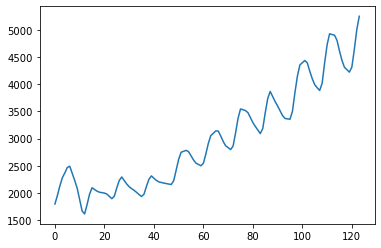

In [43]:
full_data['Sales'].plot()
plt.show()

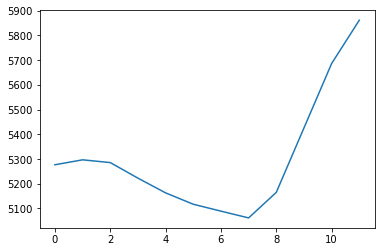

In [44]:
full_data['Predicted'].plot()
plt.show()

<AxesSubplot:>

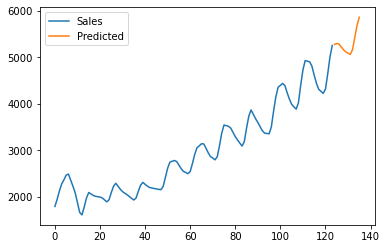

In [45]:
full_data[['Sales','Predicted']].reset_index(drop=True).plot()

## 2. Data Driven Forecasting Techniques

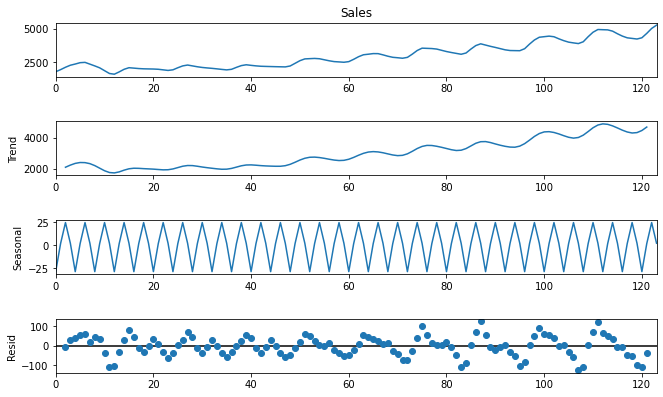

In [46]:
seasonal_de_compose=seasonal_decompose(monthly_sales['Sales'],period=4)
fig=seasonal_de_compose.plot()
fig.set_size_inches(10,6)
plt.show()

### Set 1 :

### Simple Average Model

In [47]:
monthly_sales['Simple_Average']=pd.Series()
for i in range (0,monthly_sales.shape[0]):
    avg=np.round(np.mean(monthly_sales['Sales'][:i]))
    monthly_sales['Simple_Average'].at[i]=avg
monthly_sales.head()

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,1,0,0,0,0,0,0,0,0,1794.0
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,0,0,0,0,1,0,0,0,0,1872.0
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,0,0,0,0,0,0,0,0,0,1957.0
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,0,0,0,0,0,1,0,0,0,2037.0


In [48]:
monthly_sales=monthly_sales.fillna(0)
monthly_sales.head()

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,1,0,0,0,0,0,0,0,0,1794.0
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,0,0,0,0,1,0,0,0,0,1872.0
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,0,0,0,0,0,0,0,0,0,1957.0
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,0,0,0,0,0,1,0,0,0,2037.0


In [49]:
rmse_avg=np.round(mean_squared_error(monthly_sales.Sales,monthly_sales.Simple_Average,squared=False),3)
rmse_avg

953.175

### Moving Average Model

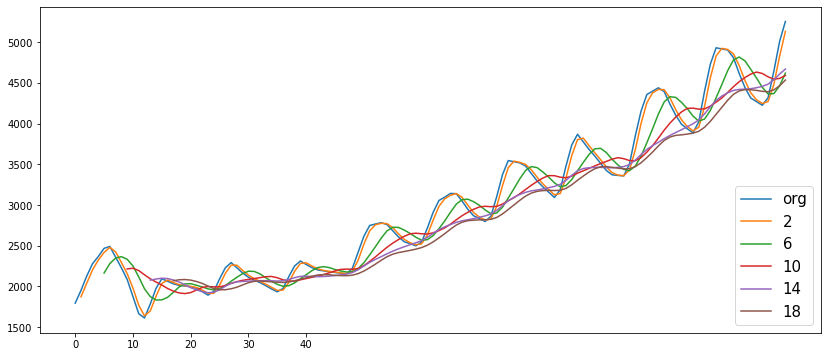

In [50]:
#Plotting Moving average model

plt.figure(figsize=(14,6))
monthly_sales['Sales'].plot(label='org')
for i in range(2,19,4):
    monthly_sales['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='lower right',fontsize =15)
plt.xticks(np.arange(0,50,10))
plt.show()

In [51]:
monthly_sales['Moving_Average']=monthly_sales['Sales'].rolling(3).mean().round()

In [52]:
monthly_sales=monthly_sales.fillna(0)
monthly_sales.head()

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average,Moving_Average
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,...,0,0,0,0,0,0,0,0,1794.0,0.0
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,...,0,0,0,1,0,0,0,0,1872.0,1957.0
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,...,0,0,0,0,0,0,0,0,1957.0,2119.0
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,...,0,0,0,0,1,0,0,0,2037.0,2257.0


In [53]:
rmse_moving_avg=np.round(mean_squared_error(monthly_sales.Sales,monthly_sales.Moving_Average,squared=False),3)
rmse_moving_avg

268.433

### Weighted Moving Average Model

In [54]:
weights=[0.2,0.3,0.5]
sum_weights=np.sum(weights)

In [55]:
monthly_sales['Weighted_Moving_Average']=monthly_sales['Sales'].rolling(3).apply(lambda x : np.sum(x*weights)/sum_weights,).round()

In [56]:
monthly_sales=monthly_sales.fillna(0)
monthly_sales.head()

,Sales,date,year,month,t,t_square,log_sales,Apr,Aug,Dec,...,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average,Moving_Average,Weighted_Moving_Average
0,1793.75,1986-01-31,1986,Jan,1,1,7.492064,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,1950.75,1986-02-28,1986,Feb,2,4,7.575969,0,0,0,...,0,0,0,0,0,0,0,1794.0,0.0,0.0
2,2127.20,1986-03-31,1986,Mar,3,9,7.662562,0,0,0,...,0,0,1,0,0,0,0,1872.0,1957.0,2008.0
3,2278.25,1986-04-30,1986,Apr,4,16,7.731163,1,0,0,...,0,0,0,0,0,0,0,1957.0,2119.0,2167.0
4,2367.00,1986-05-31,1986,May,5,25,7.769379,0,0,0,...,0,0,0,1,0,0,0,2037.0,2257.0,2292.0


In [57]:
rmse_weighted_moving_avg=np.round(mean_squared_error(monthly_sales.Sales,monthly_sales.Weighted_Moving_Average,squared=False),3)
rmse_weighted_moving_avg

253.495

#### Simple Average, Moving average, Weighted Moving average calculation done for finding least RMSE, which is Weighted Moving Average amonth these three.

### Set - 2

### Simple Exponential Smoothing Technique

In [58]:
ses=SimpleExpSmoothing(endog=training_data['Sales']).fit(smoothing_level=0.2)

pred_ses = ses.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_ses=np.round(mean_squared_error(testing_data['Sales'],pred_ses,squared=False),3)
rmse_ses

424.476

### Holts Technique

In [59]:
holt=Holt(endog=training_data['Sales']).fit(smoothing_level=0.8,smoothing_slope=0.2)

pred_holt = holt.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_holt=np.round(mean_squared_error(testing_data['Sales'],pred_holt,squared=False),3)
rmse_holt

1291.005

### Winter's Exponential Technique - Additive Seasonality and Additive Trend

In [60]:
winter_add_add=ExponentialSmoothing(endog=training_data['Sales'],seasonal='add',trend='add',seasonal_periods=12).fit()

pred_winter_add_add = winter_add_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_add_add=np.round(mean_squared_error(testing_data['Sales'],pred_winter_add_add,squared=False),3)
rmse_winter_add_add

534.226

### Winter's Exponential Technique - Multiplicative Seasonality and Additive Trend

In [61]:
winter_mul_add=ExponentialSmoothing(endog=training_data['Sales'],seasonal='mul',trend='add',seasonal_periods=12).fit()

pred_winter_mul_add = winter_mul_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_mul_add=np.round(mean_squared_error(testing_data['Sales'],pred_winter_mul_add,squared=False),3)
rmse_winter_mul_add

92.79

### Compare the Results

In [62]:
pd.set_option('display.max_colwidth',None)
Data_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Simple Exponential Smoothing','Holts','Winters Exponential Technique - Additive Seasonality and Additive Trend','Winters Exponential Technique - Multiplicative Seasonality and Additive Trend']),
          "RMSE":pd.Series([rmse_ses,rmse_holt,rmse_winter_add_add,rmse_winter_mul_add])})
Data_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
3,Winters Exponential Technique - Multiplicative Seasonality and Additive Trend,92.790
0,Simple Exponential Smoothing,424.476
2,Winters Exponential Technique - Additive Seasonality and Additive Trend,534.226
1,Holts,1291.005


#### From above table, we consider that Winters Exponential Technique - Multiplicative Seasonality and Additive Trend Model gives Less RMSE Value

### Build model for Complete Dataset

In [63]:
winter_mul_add_final=ExponentialSmoothing(endog=monthly_sales['Sales'],seasonal='mul',trend='add',seasonal_periods=12).fit()
winter_mul_add_final.forecast(12)

124    5231.499542
125    5193.459792
126    5075.518225
127    4866.356749
128    4688.438131
129    4561.598267
130    4514.391711
131    4468.241970
132    4595.030616
133    4986.976996
134    5388.391149
135    5648.814808
dtype: float64

## 3. ARIMA

### Evaluate Arima Model

In [64]:
def evaluate_arima_model(X,arima_order):
    train_size=int(len(X)*0.5)
    train,test = X[0:train_size],X[train_size:]
    history = [i for i in train]
    predictions = list()
    for t in range(0,len(test)):
        model = ARIMA(endog =history,order = arima_order).fit(disp=0)
        yhat  = model.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    RMSE = mean_squared_error(test, predictions,squared=False)
    return RMSE

### Grid Search for ARIMA Order

In [65]:
def evaluate_order(dataset, p_values, q_values, d_values):
    dataset = dataset.astype('float32')
    best_score,best_order = float('inf'),None
    for p in p_values:
        for q in q_values:
            for d in d_values:
                try:
                    order = (p,q,d)
                    rmse = evaluate_arima_model(dataset,order)
                    print(f"RMSE is {rmse} and Order is {order}")
                    if rmse < best_score:
                        best_score,best_order = rmse,order
                except:
                    continue
    print(f"Best Score is {best_score} and Best Order is {best_order}")         

In [66]:
data = monthly_sales.iloc[:,0]
data = data.values
train_size=int(len(data)-12)
train_data,test_data = data[0:train_size],data[train_size:]
train_data.shape,test_data.shape

((112,), (12,))

In [67]:
p_values = range(0,4)
q_values = range(0,4)
d_values = range(0,4)
warnings.filterwarnings('ignore')
evaluate_order(train_data,p_values, q_values, d_values)

RMSE is 1100.2271975468661 and Order is (0, 0, 0)
RMSE is 579.3980358423278 and Order is (0, 0, 1)
RMSE is 142.53257537127035 and Order is (0, 1, 0)
RMSE is 89.95716116119266 and Order is (0, 1, 1)
RMSE is 95.94314208871043 and Order is (0, 2, 0)
RMSE is 82.33593195449872 and Order is (0, 2, 1)
RMSE is 86.18850136701367 and Order is (0, 2, 2)
RMSE is 65.7222670238618 and Order is (0, 2, 3)
RMSE is 149.9667104163374 and Order is (1, 0, 0)
RMSE is 91.09302392442262 and Order is (1, 1, 0)
RMSE is 74.82517097674523 and Order is (1, 1, 1)
RMSE is 64.31390947666218 and Order is (1, 1, 2)
RMSE is 66.67704084428989 and Order is (1, 1, 3)
RMSE is 88.01604573315147 and Order is (1, 2, 0)
RMSE is 83.35198356349812 and Order is (1, 2, 1)
RMSE is 99.31089010175411 and Order is (2, 0, 0)
RMSE is 80.71405200282132 and Order is (2, 0, 1)
RMSE is 68.18036526487593 and Order is (2, 0, 2)
RMSE is 69.9933549247185 and Order is (2, 0, 3)
RMSE is 71.04366403348547 and Order is (2, 1, 0)
RMSE is 71.811531623

### Build Model based on Optimum Arima Order

In [68]:
model_final = ARIMA(train_data,(3, 1, 3)).fit()

In [69]:
forecast=model_final.forecast(12)[0].round()
forecast

array([4891., 4795., 4644., 4526., 4459., 4451., 4487., 4548., 4614.,
       4670., 4713., 4741.])

In [70]:
test_data

array([4915.5 , 4902.75, 4808.6 , 4614.  , 4441.  , 4313.  , 4268.5 ,
       4224.  , 4316.  , 4642.  , 5008.8 , 5253.  ])

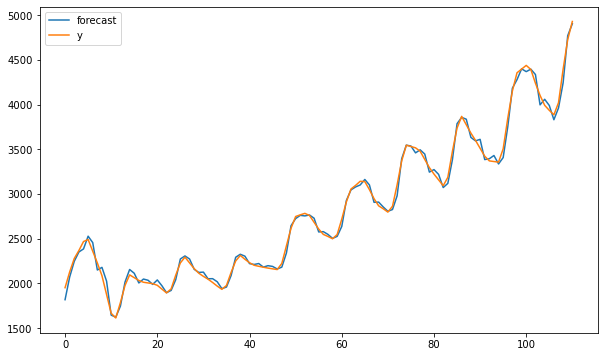

In [71]:
fig=model_final.plot_predict()
fig.set_size_inches(10,6)
plt.show()

In [72]:
RMSE_Optimum = np.round(mean_squared_error(test_data,forecast,squared=False))
RMSE_Optimum

234.0

#### RMSE by ARIMA Model is 234

### Evaluate for complete dataset

In [73]:
model_final_full_dataset = ARIMA(data,(3, 2, 0)).fit()

In [74]:
forecast=model_final_full_dataset.forecast(12)[0].round()
forecast

array([5399., 5530., 5692., 5883., 6081., 6272., 6455., 6636., 6820.,
       7005., 7192., 7380.])

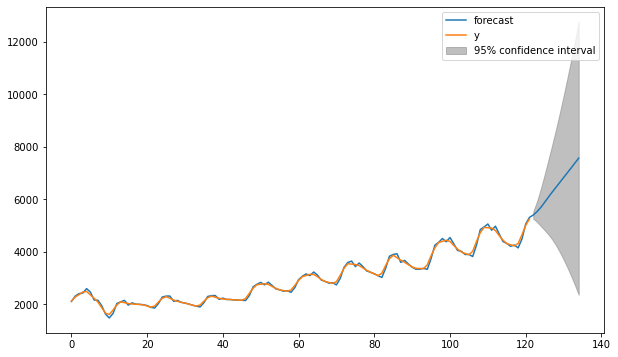

In [75]:
fig=model_final_full_dataset.plot_predict(2,136)
fig.set_size_inches(10,6)
plt.show()

### End !!!